In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(265,265),
    batch_size=32
)

Found 2152 files belonging to 3 classes.


In [9]:
len(dataset)

68

In [30]:
2152/32

67.25

In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

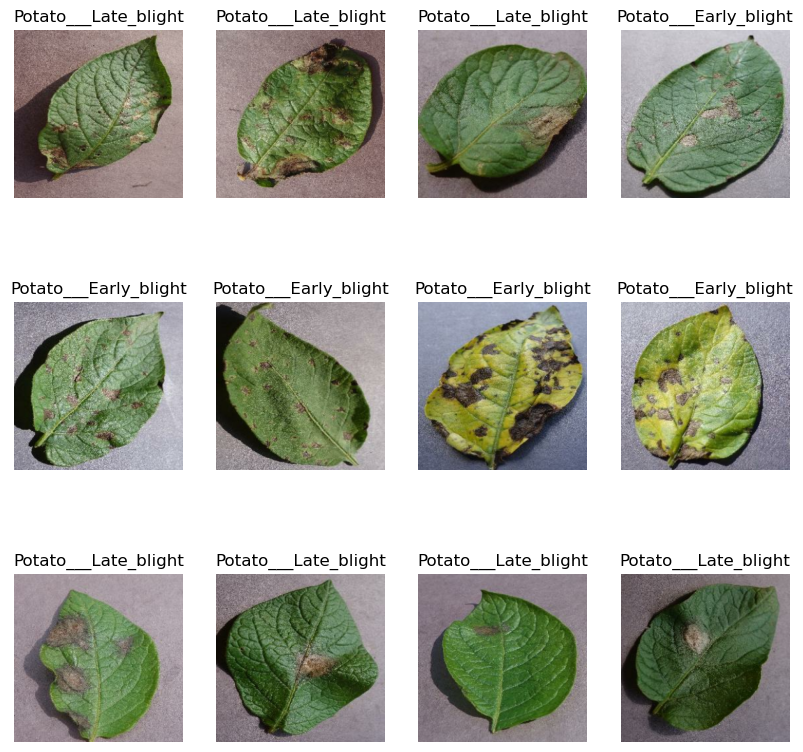

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [33]:
training_size = len(dataset)*0.8
training_size

54.400000000000006

In [34]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)

In [35]:
val_size = len(dataset)*0.1
val_size

6.800000000000001

In [36]:
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

In [12]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1, "Splits must sum to 1"

    ds_size = sum(1 for _ in ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size  # Ensure the splits sum to the dataset size
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [13]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [14]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))


54
6
8


In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1./255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])


In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

In [19]:


model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\rushi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)






Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 627ms/step - accuracy: 0.4393 - loss: 0.9585 - val_accuracy: 0.6562 - val_loss: 0.8279
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 665ms/step - accuracy: 0.6421 - loss: 0.7604 - val_accuracy: 0.7552 - val_loss: 0.5659
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 676ms/step - accuracy: 0.7905 - loss: 0.4938 - val_accuracy: 0.8229 - val_loss: 0.3979
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 630ms/step - accuracy: 0.8778 - loss: 0.3305 - val_accuracy: 0.9375 - val_loss: 0.1864
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 620ms/step - accuracy: 0.8898 - loss: 0.2903 - val_accuracy: 0.9115 - val_loss: 0.2184
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 626ms/step - accuracy: 0.9142 - loss: 0.2105 - val_accuracy: 0.9531 - val_loss: 0.1418
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 621ms/step - accuracy: 0.9507 - loss: 0.1293 - val_accuracy: 0.9427 - val_loss: 0.1024
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 675ms/step - accuracy: 0.9711 - loss: 0.0618 - val_accu

In [48]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.9936 - loss: 0.1105


In [51]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [53]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [58]:
acc = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

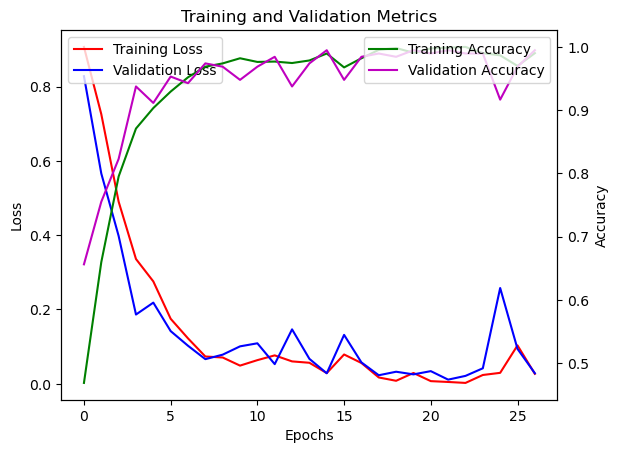

In [61]:
fig, ax1 = plt.subplots()

# Plotting loss vs epochs
ax1.plot(history.history['loss'], label='Training Loss', color='r')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

# Creating a twin axes sharing the x-axis
ax2 = ax1.twinx()
# Plotting accuracy vs epochs
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='g')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='m')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

plt.title('Training and Validation Metrics')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
actual label: Potato___Late_blight
Predicted_Image =  Potato___Late_blight


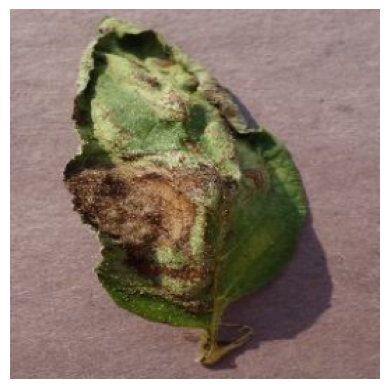

In [73]:
for image_batch,label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    plt.imshow(first_image)
    plt.axis(False)
    predicted = model.predict(image_batch)
    print("actual label:",class_names[first_label])
    print('Predicted_Image = ',class_names[np.argmax(predicted[0])])

In [77]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


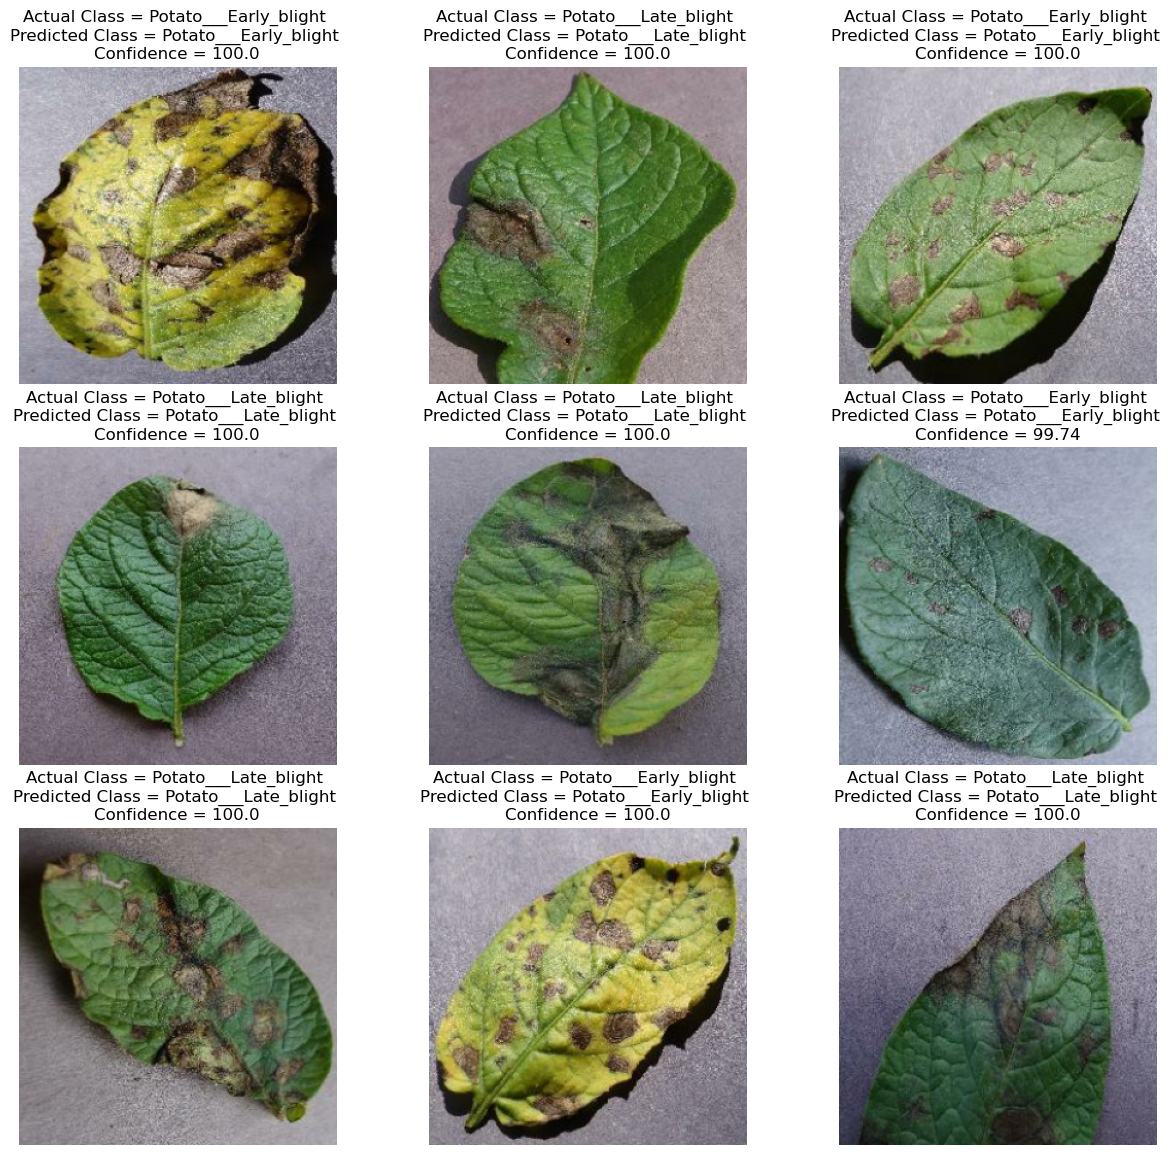

In [84]:
plt.figure(figsize = (15,14))
for images_batch, label_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        plt.imshow(image)
        plt.axis('off')  # Corrected argument to 'off'
        predicted_class, confidence = predict(model, image)  # Corrected variable usage
        plt.title(f'Actual Class = {name} \nPredicted Class = {predicted_class} \nConfidence = {confidence}')
       
    plt.show()

In [89]:
import os
save_dir = os.path.join( 'models')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model_name = 'my_model.keras'
save_path = os.path.join(save_dir, model_name)
model.save(save_path)
print(f'Model saved to {save_path}')

Model saved to models\my_model.keras
